# Solving time dependent systems

## Stochastic heat equation

We will solve 

\begin{align}
&du = \Delta u dt  + dW_t \\
&u(0, x) = g(x) \\
&u(t,0) = u(t, 1) = 0
\end{align}

where $\frac{dW_t}{dt}$ is space time white noise. We use an implicit EM method with step size $h$

\begin{align}
&u_0 = g(x) \\
&u_{n+1} = u_n + h \Delta u_{n+1} + \Delta W_n
\end{align}
where 
$$
\Delta W_n \sim \mathcal{N}(0, h I)
$$

Hence 
\begin{align}
&(-h \Delta + I )u_{n+1} = u_n + \Delta W_n\\
&u(t,0) = u(t, 1) = 0
\end{align}

At each step we solve

\begin{align}
[(-h \Delta + I )u_{n+1}, \psi] = [u_n,\psi] + \sqrt{h}[\Delta \xi_n, \psi]
\end{align}



In [1]:
import jax.numpy as jnp
from jax import random, vmap, jit, grad
import jax.scipy as scipy


from jax.config import config
config.update("jax_enable_x64", True)

import matplotlib.pyplot as plt

from utils_rough_pde import *
from utils_elliptic_coef import *

from utils_optim import kernel_linear_solver

C:\Users\Matthieu\AppData\Local\Temp\ipykernel_17772\3464410477.py:6: DeprecationWarning: Accessing jax.config via the jax.config submodule is deprecated.
  from jax.config import config


In [2]:
# Define the domain of the problem
L = 1.0
lower = 0.0
upper = L
x = jnp.linspace(0, 1, 10000)
boundary = jnp.array([[lower, upper]]).T


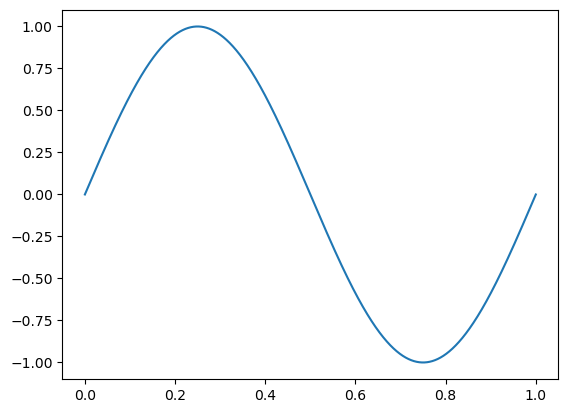

In [3]:
# Initial condition
def u0(x):
    return jnp.sin(2*jnp.pi*x)

g_init = u0(x)

plt.plot(x, g_init)
plt.show()

In [4]:
N_m = 500
centers = jnp.linspace(0, L, int(N_m))[1:-1]
N_tent = len(centers)
epsilon = centers[1] - centers[0]
epsilon

Array(0.00200401, dtype=float64)

In [5]:
stiffness_matrix = vmap_compute_energy_ip(epsilon, centers, centers)
L2_matrix = vmap_compute_l2_ip(epsilon, centers, centers)
L_stiff = scipy.linalg.cho_factor(stiffness_matrix + 1e-10*jnp.eye(N_tent))
#L = scipy.linalg.cholesky(L2_matrix, lower=True)
#stiffness_matrix, L2_matrix

In [6]:
# Build the measurements of the initial condition

# Define the support of the test function 
support = jnp.array([centers - epsilon
                     , centers + epsilon]).T

from scipy.special import roots_legendre
n_order = 10
x_q, w_q = roots_legendre(n_order)
x_interval, w_interval = vmap_root_interval(x_q, w_q, support)

from utils_rough_pde import vmap_integrate_f_test_functions
# Create measurements of f 
root_psi, w_psi = vmap_root_interval(x_q, w_q, support)
psi_matrix = vmap_tent_vector(root_psi, epsilon, centers)
psi_matrix = psi_matrix * w_psi

In [7]:
y_init = u0(root_psi)
y_init = vmap_integrate_f_test_functions(y_init, psi_matrix)

In [8]:
U, s, Vt = jnp.linalg.svd(L2_matrix)
def sample_from_degenerate_gaussian(U, s, key,size=1):
    # Perform SVD on the covariance matrix
    #U, s, Vt = jnp.linalg.svd(cov)
    
    # Keep only the non-zero components (up to numerical stability)
    nonzero_indices = s > 1e-10  # Adjust this threshold as necessary
    s_nonzero = s[nonzero_indices]
    U_nonzero = U[:, nonzero_indices]
    
    # Sample from a lower-dimensional Gaussian
    lower_dim_samples = random.normal(key, shape = (len(s_nonzero), size))
    
    # Scale samples by the square root of the nonzero singular values
    scaled_samples = jnp.sqrt(s_nonzero)[:, jnp.newaxis] * lower_dim_samples
    
    # Transform the samples back to the original space
    samples =  U_nonzero @ scaled_samples
    
    return samples.T

#sample_from_degenerate_gaussian(U, s, random.key(0),size=1)[0]

In [9]:
def implicit_Euler_linear(T, h, linear_solver, y_init,sigma, L_stiff, L2_matrix, reg, key):
    U, s, Vt = jnp.linalg.svd(L2_matrix  + 1e-10*jnp.eye(N_tent))

    # Number of time steps
    N = int(T/h)
    time = jnp.arange(h, T+h, h)
    y = y_init

    for i in range(N):
        key, subkey = random.split(key)
        # Sample from the space time white noise
        xi = sample_from_degenerate_gaussian(U, s, subkey, size=1)[0]

        # Create the right hand side
        rhs = y + sigma*jnp.sqrt(h)*xi
        #print(xi[0])

        # Solve the linear system
        linear_solver.solve(rhs, reg, L_stiff)

        # Update the rhs
        y = linear_solver.evaluate_solution_psi()        
        #print(y.shape)
    return y, linear_solver

In [10]:
T= 10.0 
sigma = 1.0

length_scale = 0.1
bc = jnp.zeros(shape = (2, )) 
h = 0.1


linear_solver = kernel_linear_solver(length_scale, psi_matrix, root_psi, boundary, bc, h)
root_identity = jnp.ones_like(root_psi)

linear_solver.build_matrices(root_identity)




In [12]:
l_list = [1.0, 0.5, 0.25, 0.1]
sol_list = []
for l in l_list:
    linear_solver = kernel_linear_solver(l, psi_matrix, root_psi, boundary, bc, h)
    root_identity = jnp.ones_like(root_psi)

    linear_solver.build_matrices(root_identity)

    y, linear_solver = implicit_Euler_linear(T, h, linear_solver, y_init, sigma, L_stiff, L2_matrix, None, random.key(1))
    sol_list.append(linear_solver.evaluate_solution(x))

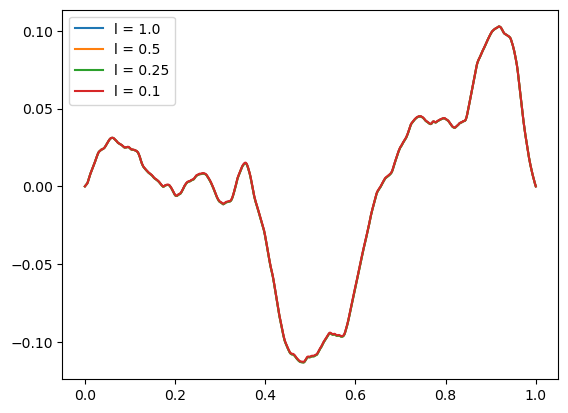

In [13]:
for i, sol in enumerate(sol_list):
    plt.plot(x, sol, label = f"l = {l_list[i]}")

plt.legend()

In [ ]:
pred= linear_solver.evaluate_solution(x)
pred_psi = linear_solver.evaluate_solution_psi()

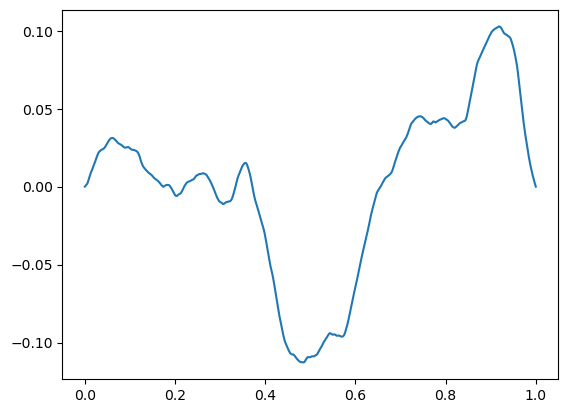

In [ ]:
plt.plot(x,pred)

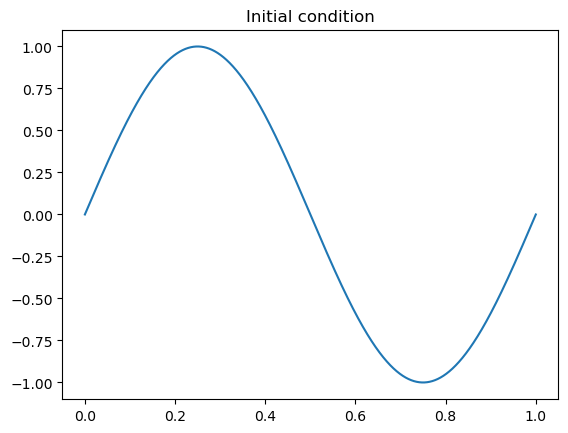

In [ ]:
plt.plot(x, g_init)
plt.title('Initial condition')
plt.show()